<a href="https://colab.research.google.com/github/mweber1151/DS_Sandbox/blob/master/WeberDisc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Import Packages, Set Style, and Load Data**

In [0]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score

# Display inline and set  style
%matplotlib inline
sns.set()

# Import test and train data
df_train = pd.read_csv('/content/drive/My Drive/MSDS422/titanic/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/MSDS422/titanic/test.csv')

**Examine Data**

In [3]:
# View first 5 rows of training data with headers
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# View first 5 rows of test data with headers
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Check training data datatypes and look for null values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Check test data datatypes and look for null values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The field Cabin is populated for less than 1/4 of the records.  Before discounting the value of the data completely, is it highly correlated with another field?

In [16]:
df_train['Cabin'].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
C22 C26        3
              ..
E58            1
C90            1
F E69          1
A32            1
B78            1
Name: Cabin, Length: 147, dtype: int64

In [21]:
df_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [15]:
df_train['Cabin_Letter'] = df_train['Cabin'].astype(str).str[0]
df_train['Cabin_Letter'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

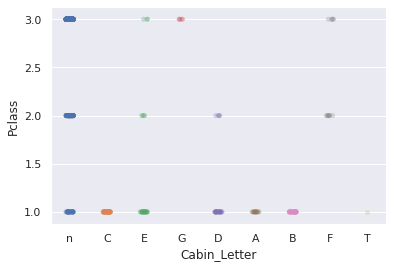

In [22]:
sns.stripplot(x='Cabin_Letter', y='Pclass', data=df_train, alpha=0.3, jitter=True);


In [24]:
df_train[df_train['Cabin_Letter'] == 'E']['Pclass'].value_counts()

1    25
2     4
3     3
Name: Pclass, dtype: int64

The Cabin values consist of a letter followed by a number (such as B96).  Looking at only the letter and comparing it to the Class (1-3), we can see that cabin letters C,A,B, & T all fall into class 1.  Cabin letter G is solely in 3rd Class, and D & F are each shared across two classes.  Letter E is the only letter shared across first, second, and third classes; the vast majority of which are in first class (25 of 32).  Based on this analysis, it is reasonable and prudent to discount the Cabin data for any modeling.

**Visualizing numeric data**
Begin with basic description of the numeric fields

In [25]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Two of the variables that dramatically impact the chance of survival are 'Sex' and 'Pclass'.  As shown below, males had a low likelihood of surviving, while females had a better than 2/3 chance of surviving.

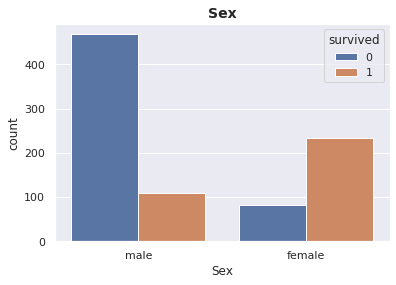

In [49]:
f, ax = plt.subplots(1, 1)
sns.countplot(df_train['Sex'], hue = df_train['Survived'], ax = ax)
ax.set_title('Sex', fontsize=14, fontweight='bold')
ax.legend(title='survived', loc = 'best')
plt.show()

'Pclass' is also a variable with a high impact on survivability.  Those in first class had a better than 50% chance of survival while second class passengers were slightly below 50% chance of survival.  Third class passengers have a less than 25% chance of survival.

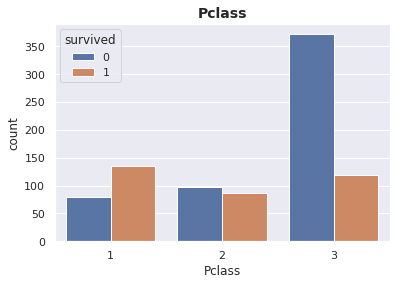

In [51]:
f, ax = plt.subplots(1, 1)
sns.countplot(df_train['Pclass'], hue = df_train['Survived'], ax = ax)
ax.set_title('Pclass', fontsize=14, fontweight='bold')
ax.legend(title='survived', loc = 'best')
plt.show()